# Feb 15, 2025: model comparison
using `total evidence, L` of a model per chain

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.stats import wilcoxon, ttest_rel
from statsmodels.stats.multitest import multipletests
from multiprocessing import Pool
import glob
import random

# import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from matplotlib.patches import Rectangle

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

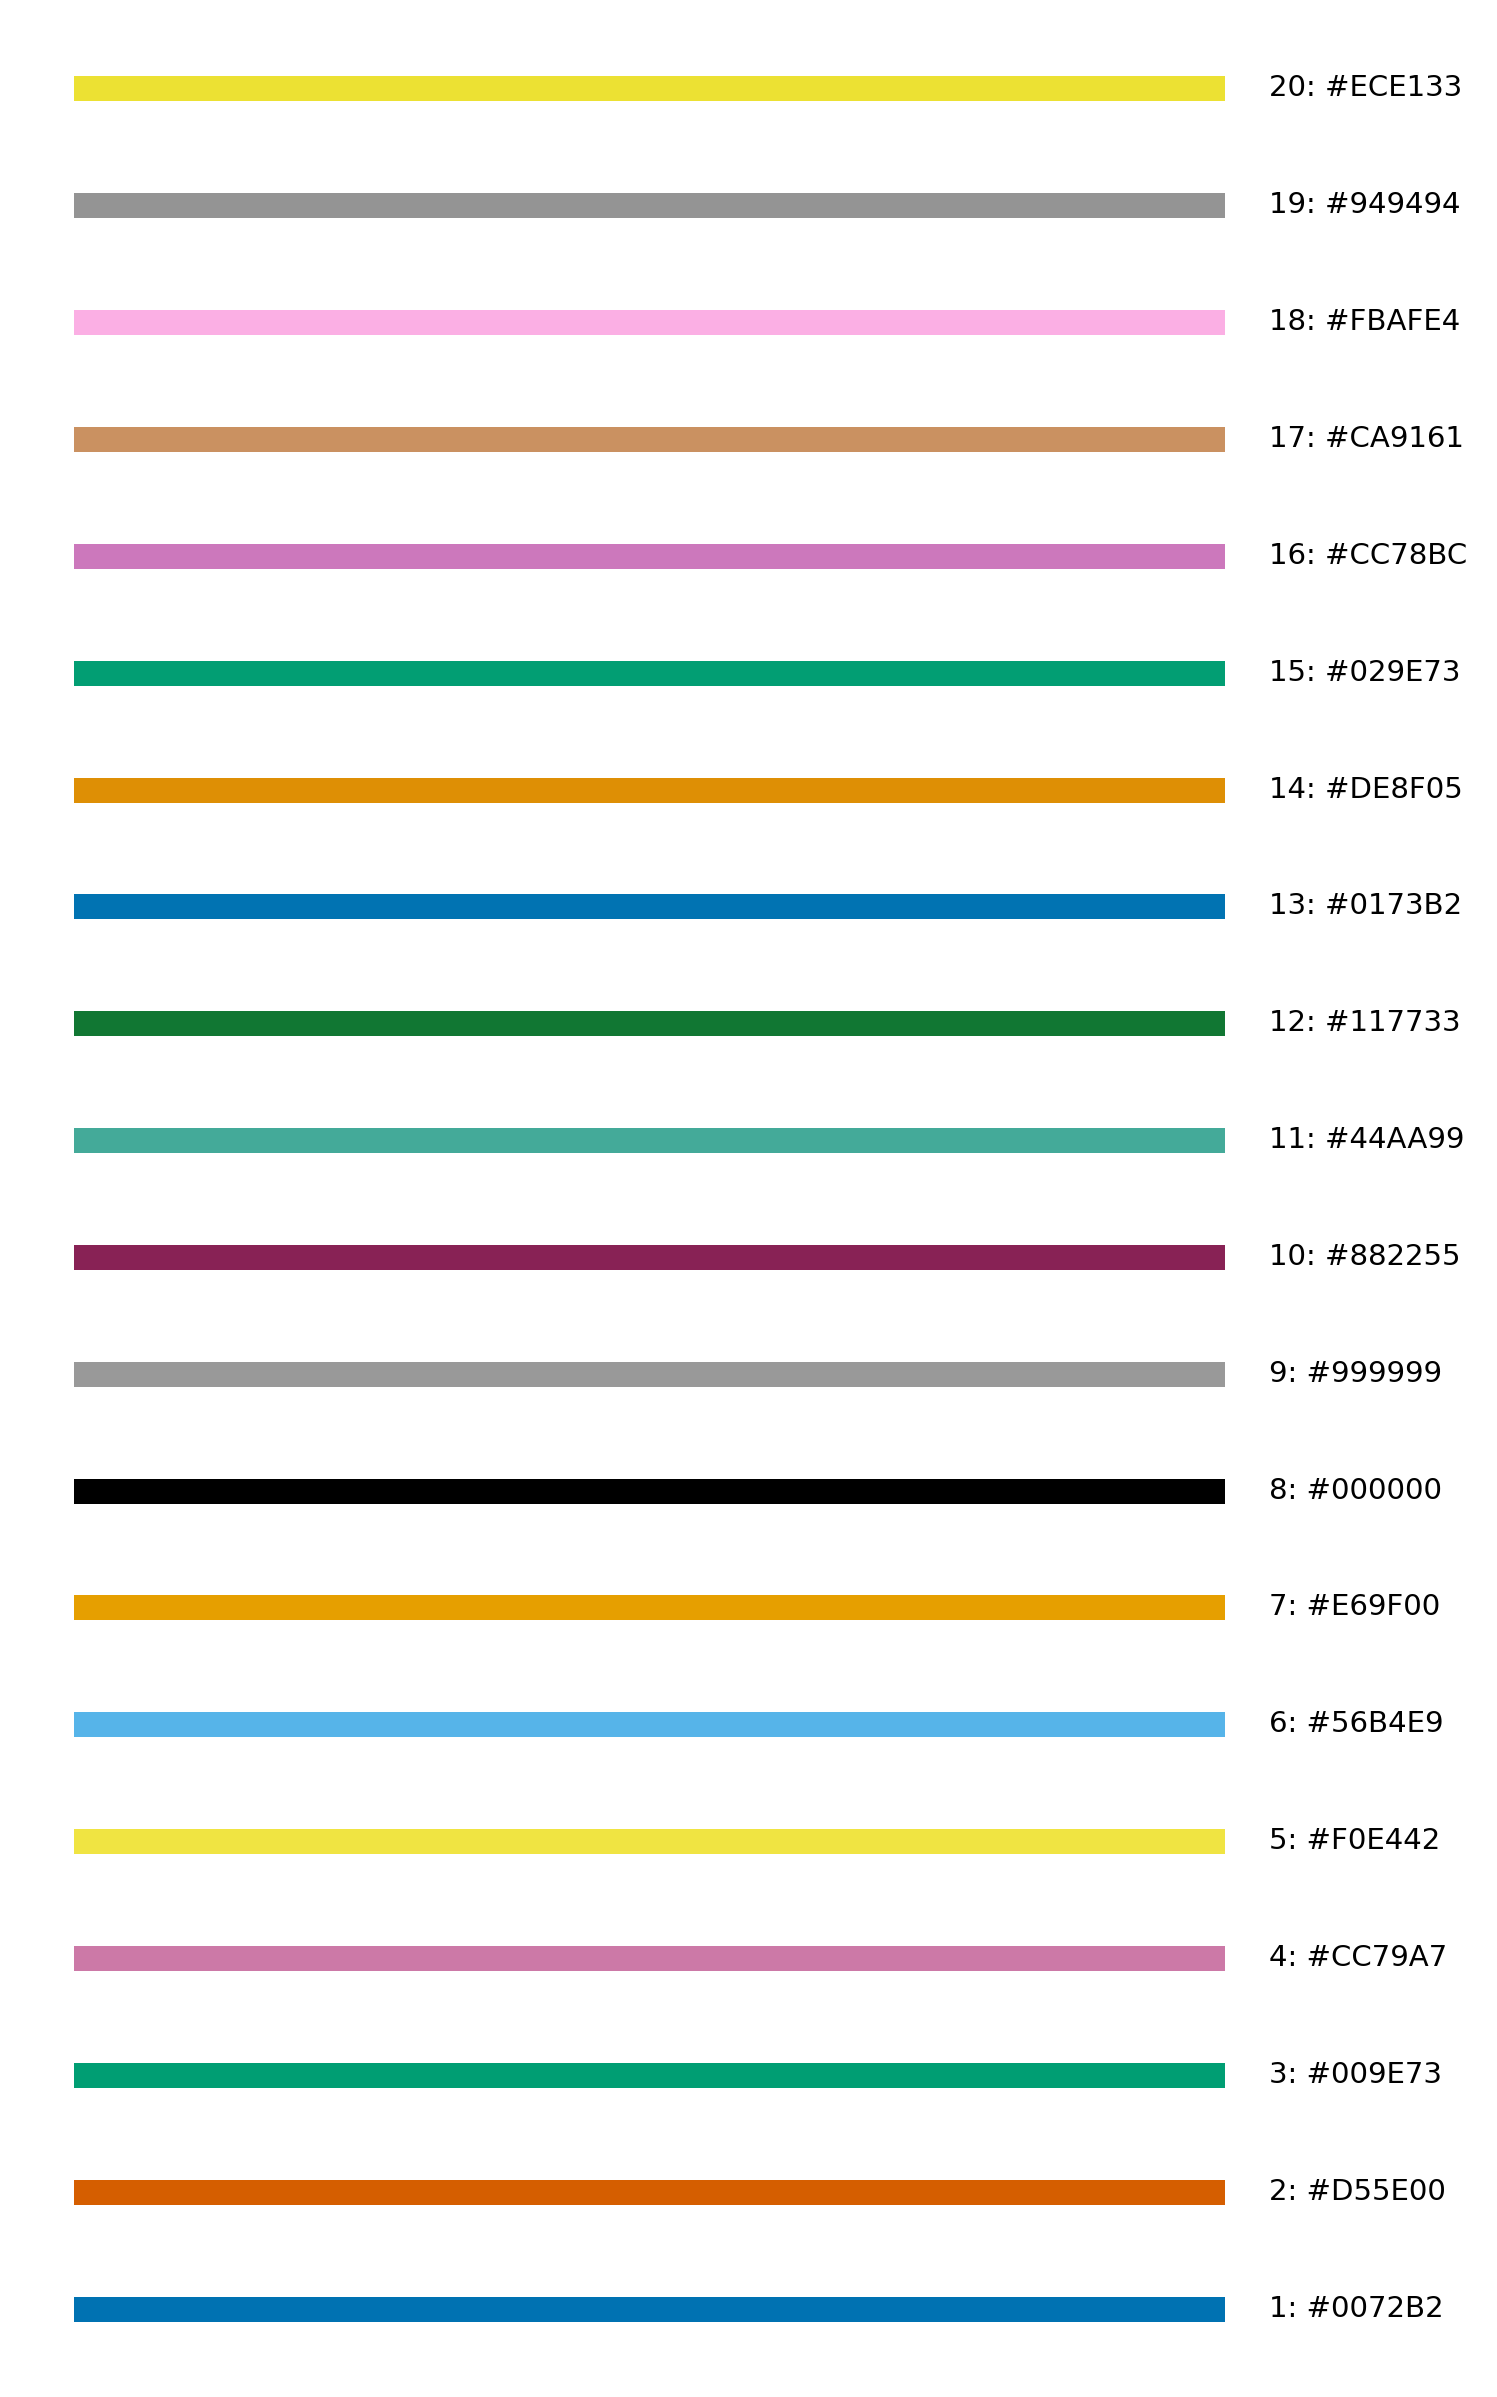

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [6]:
args.source = 'allen'
args.space = 'ccfv2'
args.brain_div = 'whl'
args.num_rois = 172
args.resolution = 200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [8]:
main_folders = sorted(glob.glob(f'{SBM_path}/*', recursive=True))
main_folders

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC01_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC03_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC04_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits/sub-SLC05_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v

In [9]:
def collect_evidences_per_sub(args, evidence_files):
    ldf = []
    for file in evidence_files:
        with open(f'{file}', 'rb') as f:
            [L] = pickle.load(f)
        sub = [s for s in file.split('/') if 'sub-' in s][0].split('_')[0].split('-')[-1]
        sbm = '-'.join([s for s in file.split('/') if 'sbm-' in s][0].split('-')[1:])
        B = [s for s in file.split('/') if 'B-' in s][0].split('-')[-1]
        if sbm in ['-m']: continue
        row = pd.DataFrame(dict(
            sbm=[sbm],
            B=[B],
            L=[-L], # flipped the sign, to convert evidence to description length
        ))
        ldf += [row]
    ldf = pd.concat(ldf).reset_index(drop=True)
    pdf = ldf.pivot(index='B', columns='sbm', values='L')
    
    return sub, ldf, pdf

def sort_sbms(pdf):
    rank_df = pdf.rank(axis=1, method='min', ascending=True)
    modal_ranks = stats.mode(rank_df.to_numpy(), axis=0).mode
    cols_sorted = [col for _, col in sorted(zip(modal_ranks, pdf.columns))]
    return pdf[cols_sorted]

In [10]:
# def compare_columns_ttest(df):
#     results = {}
#     for col1, col2 in combinations(df.columns, 2):
#         # Drop rows where either column has NaN
#         mask = df[[col1, col2]].notna().all(axis=1)
#         if mask.sum() > 1:  # need at least 2 pairs
#             stat, pval = stats.ttest_rel(df[col1][mask], df[col2][mask])
#             results[(col1, col2)] = {'t-stat': stat, 'p-value': pval}
#     comps_df = pd.DataFrame(results).T
#     # Benjamini-Hochberg: Controls FDR
#     comps_df['p-value-corr'] = multipletests(comps_df['p-value'], method='bonferroni')[1]
#     return comps_df

In [11]:
def compare_description_lengths(df, test='wilcoxon'):
    """
    Compare models (columns) using Wilcoxon signed-rank tests on description lengths.
    Lower values are better. Applies FDR correction.

    Parameters
    ----------
    df : pd.DataFrame
        Rows = subjects/animals, columns = models, values = description lengths (smaller is better).

    Returns
    -------
    pd.DataFrame
        Pairwise comparisons with raw and FDR-corrected p-values, median difference, and which model is better.
    """
    results = {}
    for col1, col2 in combinations(df.columns, 2):
        mask = df[[col1, col2]].notna().all(axis=1)
        if mask.sum() > 1:
            x1, x2 = df[col1][mask], df[col2][mask]
            if test == 'wilcoxon':
                stat, pval = wilcoxon(x1, x2, alternative='two-sided')
            elif test == 'ttest':
                result = ttest_rel(x1, x2, alternative='two-sided')
                stat, pval = result.statistic, result.pvalue
            median_diff = (x1 - x2).median()
            better_model = col1 if median_diff < 0 else col2  # Smaller DL is better
            results[(col1, col2)] = {
                'Wilcoxon Stat': stat,
                'p-value': pval,
                'Median Diff': median_diff,
                'Better Model': better_model
            }

    comps_df = pd.DataFrame(results).T
    comps_df['p-value FDR'] = multipletests(comps_df['p-value'], method='bonferroni')[1]
    return comps_df

In [12]:
def get_long_df(main_df):
    df_long = main_df.reset_index(drop=True).melt(var_name='SBM', value_name='DL')
    df_long['Animal'] = np.tile(np.arange(main_df.shape[0]), len(main_df.columns))
    df_long["SBM"] = pd.Categorical(df_long["SBM"], categories=main_df.columns.tolist(), ordered=True)
    return df_long

In [13]:
def plot_model_comparisons(args, main_df, comps_df, main_df_long):
    # TODO:
    # fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.8))
    fig, ax = plt.subplots(1, 1, figsize=(4.0, 5.0))
    fs = 7

    # Boxplots behind the lines
    sns.boxplot(
        data=main_df_long,
        x="SBM", y="DL",
        color="lightgray",
        width=0.5,
        showcaps=True,
        boxprops=dict(alpha=0.2, linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        medianprops=dict(color="black", linewidth=0.8),
        showfliers=False,
        ax=ax
    )

    sns.lineplot(
        data=main_df_long,
        x='SBM', y='DL', hue='Animal',
        units='Animal', estimator=None,
        marker='o', lw=0.8, alpha=0.4,
        palette=['gray'] * main_df.shape[0],
        ax=ax,
    )

    # Plot median line
    medians = main_df.median()
    sbm_order = main_df.columns.to_list()
    x = range(len(sbm_order))
    y = medians[sbm_order].values

    # TODO:
    # ax.plot(x, y, marker='o', color='black', lw=1.2, label='Median DL')

    # Set bracket height params
    ymin = main_df.min().min()
    y_range = main_df.max().max() - ymin
    y_start = ymin - 0.02 * y_range
    step_height = 0.07 * y_range

    # Go over consecutive model pairs
    for i in range(len(sbm_order) - 1):
        m1, m2 = sbm_order[i], sbm_order[i + 1]
        x1, x2 = i, i + 1

        # Lookup FDR p-value from wilcoxon_df
        try:
            p = comps_df.loc[(m1, m2), 'p-value FDR']
        except KeyError:
            try:
                p = comps_df.loc[(m2, m1), 'p-value FDR']
            except KeyError:
                continue

        # Convert to asterisks
        if p < 0.001: stars = '***'
        elif p < 0.01: stars = '**'
        elif p < 0.05: stars = '*'
        else: stars = ''

        # Draw bracket only if significant
        if stars:
            y = y_start + (i+1) * step_height
            ax.plot([x1 + 0.15, x1 + 0.15, x2 - 0.15, x2 - 0.15],
                    [y, y - 0.01*y_range, y - 0.01*y_range, y], lw=0.8, c='black')
            label = f'{stars}' #f"{stars}\n(p={p:.3f})"
            ax.text((x1 + x2)/2, y - 0.012*y_range, label,
                    ha='center', va='top', fontsize=5)

    # Axis formatting
    ax.set_ylabel("Description Length (−log evidence)", fontsize=fs)
    ax.set_title("Individual Description Lengths Across Models", fontsize=fs)
    ax.tick_params(axis='x', labelrotation=0, labelsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    ax.grid(axis='both', linestyle='-', alpha=0.3)
    ax.legend_.remove()

    # TODO:
    ax.set_ylim([5600, 7000])
    return fig

In [14]:
for sub_folder in main_folders[:]:
    evidence_files = sorted(glob.glob(f'{sub_folder}/sbm-*/B-*/desc-evidence.pkl', recursive=True))
    sub, ldf, pdf = collect_evidences_per_sub(args, evidence_files)
    pdf = sort_sbms(pdf)
    comps_df = compare_description_lengths(pdf)
    df_long = get_long_df(pdf)
    fig = plot_model_comparisons(sub, pdf, comps_df, df_long)

    out_folder = f'{ESTIM_path}/individual/sub-{sub}/model-comparison'
    os.system(f'mkdir -p {out_folder}')

    with open(f'{out_folder}/desc-evidences.pkl', 'wb') as f:
        pickle.dump(pdf, f)

    with open(f'{out_folder}/desc-comparisons.pkl', 'wb') as f:
        pickle.dump(comps_df, f)

    fig.savefig(f'{out_folder}/desc-plot.svg', bbox_inches='tight')

    plt.close('all')
    # display(pdf)
    # display(comps_df)
    # break

In [15]:
sub

'SLC10'

In [16]:
pdf

sbm,nd-h,nd-d,dc-h,dc-d,nd-o,dc-o,-a
B,,,,,,,
1,5928.904474,6022.961246,6095.138584,6190.409241,6304.337746,6408.249191,6616.625088
112,5928.940001,6022.674592,6094.574504,6191.301208,6301.335152,6402.894697,6616.654712
224,5931.791973,6022.750592,6096.532588,6190.803595,6301.627743,6403.165513,6616.644724
335,5928.080196,6019.907977,6094.019585,6190.037903,6301.035748,6404.172523,6615.650048
446,5930.909078,6022.283978,6097.946912,6189.206036,6302.356424,6401.021436,6632.830191


group level aggregation

In [17]:
main_df = []
for sub_folder in main_folders[:]:
    evidence_files = sorted(glob.glob(f'{sub_folder}/sbm-*/B-*/desc-evidence.pkl', recursive=True))
    sub, ldf, pdf = collect_evidences_per_sub(args, evidence_files)
    cols = list(pdf.median().index)
    vals = np.array(list(pdf.mean()))[None, :]
    row = pd.DataFrame(data=vals, columns=cols)
    main_df += [row]
main_df = pd.concat(main_df).reset_index(drop=True)

In [18]:
main_df['nd-o'] += 50
main_df['dc-o'] += 50

In [19]:
main_df

,-a,dc-d,dc-h,dc-o,nd-d,nd-h,nd-o
0,6879.297602,6125.868552,6012.961011,6409.587622,5971.891715,5851.017727,5329.894379
1,6784.337555,6110.958693,5978.006479,6378.655672,5950.053013,5798.532731,6297.920674
2,6798.385812,6100.954056,5978.814832,6383.757957,5951.756421,5821.653182,6289.572688
3,6820.341857,6321.655704,6230.966263,6610.238603,6156.447025,6053.917957,6512.464693
4,6627.307683,5980.622436,5861.128743,6235.934955,5851.232742,5708.599879,6156.161020
5,6459.985749,6036.686534,5942.029951,6284.754758,5894.364313,5781.416145,6196.380501
6,6833.139658,6157.862813,6033.944117,6426.044701,5981.536043,5847.993527,6326.931452
7,6964.370484,6248.092010,6143.756911,6532.067770,6101.250665,5974.486527,6447.728443
8,6619.680953,6190.351597,6095.642435,6453.900672,6022.115677,5929.725144,6352.138562


In [20]:
main_df = sort_sbms(main_df)
main_df

,nd-h,nd-d,dc-h,dc-d,nd-o,dc-o,-a
0,5851.017727,5971.891715,6012.961011,6125.868552,5329.894379,6409.587622,6879.297602
1,5798.532731,5950.053013,5978.006479,6110.958693,6297.920674,6378.655672,6784.337555
2,5821.653182,5951.756421,5978.814832,6100.954056,6289.572688,6383.757957,6798.385812
3,6053.917957,6156.447025,6230.966263,6321.655704,6512.464693,6610.238603,6820.341857
4,5708.599879,5851.232742,5861.128743,5980.622436,6156.161020,6235.934955,6627.307683
5,5781.416145,5894.364313,5942.029951,6036.686534,6196.380501,6284.754758,6459.985749
6,5847.993527,5981.536043,6033.944117,6157.862813,6326.931452,6426.044701,6833.139658
7,5974.486527,6101.250665,6143.756911,6248.092010,6447.728443,6532.067770,6964.370484
8,5929.725144,6022.115677,6095.642435,6190.351597,6352.138562,6453.900672,6619.680953


In [21]:

main_df_long = get_long_df(main_df)

In [22]:
main_df_long

,SBM,DL,Animal
0,nd-h,5851.017727,0
1,nd-h,5798.532731,1
2,nd-h,5821.653182,2
3,nd-h,6053.917957,3
4,nd-h,5708.599879,4
...,...,...,...
58,-a,6627.307683,4
59,-a,6459.985749,5
60,-a,6833.139658,6
61,-a,6964.370484,7


In [23]:
comps_df = compare_description_lengths(main_df)
comps_df

Wilcoxon Stat   p-value Median Diff Better Model p-value FDR
nd-h nd-d           0.0  0.003906 -126.764138         nd-h    0.082031
     dc-h           0.0  0.003906  -165.91729         nd-h    0.082031
     dc-d           0.0  0.003906 -273.605483         nd-h    0.082031
     nd-o           9.0  0.128906 -458.546736         nd-h           1
     dc-o           0.0  0.003906 -557.581243         nd-h    0.082031
     -a             0.0  0.003906  -976.73263         nd-h    0.082031
nd-d dc-h           0.0  0.003906  -42.506246         nd-d    0.082031
     dc-d           0.0  0.003906 -153.976837         nd-d    0.082031
     nd-o           9.0  0.128906 -337.816267         nd-d           1
     dc-o           0.0  0.003906 -431.784995         nd-d    0.082031
     -a             0.0  0.003906 -834.284541         nd-d    0.082031
dc-h dc-d           0.0  0.003906  -112.90754         dc-h    0.082031
     nd-o           9.0  0.128906 -292.987335         dc-h           1
     dc-o           0.0  0.003906 -388.310858         dc-h    0.082031
     -a             0.0  0.003906  -799.19554         dc-h    0.082031
dc-d nd-o           9.0  0.128906 -175.538584         dc-d           1
     dc-o           0.0  0.003906 -268.181888         dc-d    0.082031
     -a             0.0  0.003906 -673.378862         dc-d    0.082031
nd-o dc-o           0.0  0.003906  -94.185269         nd-o    0.082031
     -a             0.0  0.003906 -486.416881         nd-o    0.082031
dc-o -a             0.0  0.003906 -405.681882         dc-o    0.082031

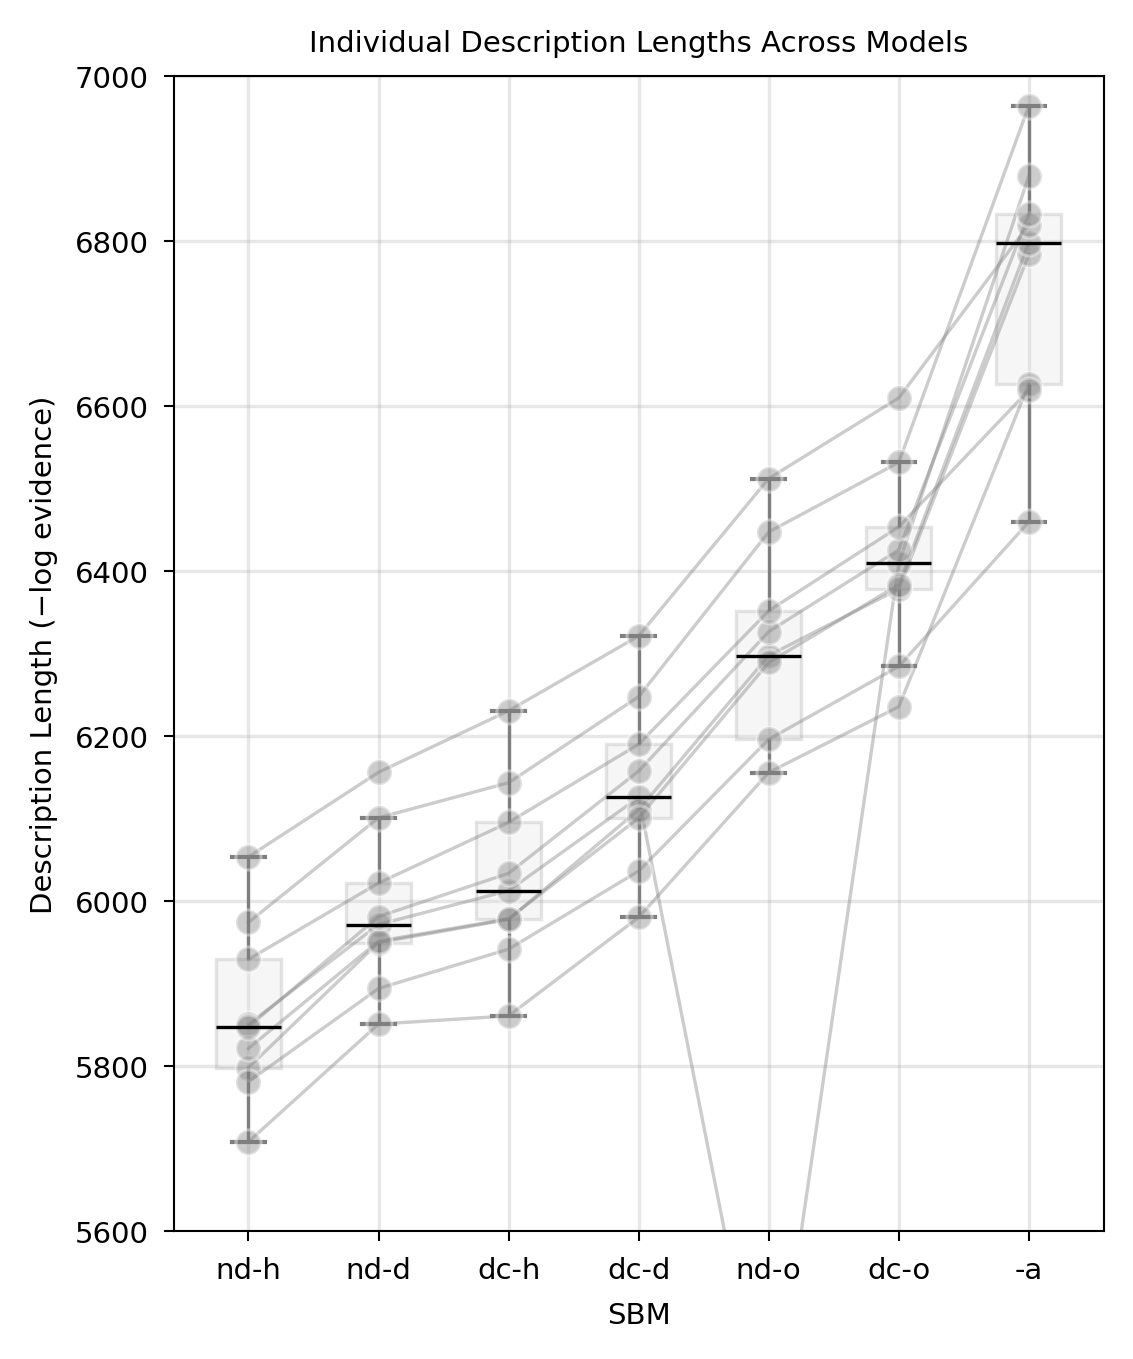

In [24]:
fig = plot_model_comparisons(args, main_df, comps_df, main_df_long)

In [25]:
out_folder = f'{ESTIM_path}/group/model-comparison'
os.system(f'mkdir -p {out_folder}')

with open(f'{out_folder}/desc-evidences.pkl', 'wb') as f:
    pickle.dump(main_df, f)

with open(f'{out_folder}/desc-comparisons.pkl', 'wb') as f:
    pickle.dump(comps_df, f)

fig.savefig(f'{out_folder}/desc-plot.svg', format='svg', bbox_inches='tight')

---

In [26]:
main_df

,nd-h,nd-d,dc-h,dc-d,nd-o,dc-o,-a
0,5851.017727,5971.891715,6012.961011,6125.868552,5329.894379,6409.587622,6879.297602
1,5798.532731,5950.053013,5978.006479,6110.958693,6297.920674,6378.655672,6784.337555
2,5821.653182,5951.756421,5978.814832,6100.954056,6289.572688,6383.757957,6798.385812
3,6053.917957,6156.447025,6230.966263,6321.655704,6512.464693,6610.238603,6820.341857
4,5708.599879,5851.232742,5861.128743,5980.622436,6156.161020,6235.934955,6627.307683
5,5781.416145,5894.364313,5942.029951,6036.686534,6196.380501,6284.754758,6459.985749
6,5847.993527,5981.536043,6033.944117,6157.862813,6326.931452,6426.044701,6833.139658
7,5974.486527,6101.250665,6143.756911,6248.092010,6447.728443,6532.067770,6964.370484
8,5929.725144,6022.115677,6095.642435,6190.351597,6352.138562,6453.900672,6619.680953


In [27]:
df = main_df
# test = 'ttest'
test = 'wilcoxon'
for col1, col2 in combinations(df.columns, 2):
    mask = df[[col1, col2]].notna().all(axis=1)
    x1, x2 = df[col1][mask], df[col2][mask]
    if test == 'ttest':
        res = ttest_rel(x1, x2, alternative='two-sided')
        stat, pval = res.statistic, res.pvalue
    elif test == 'wilcoxon':
        res = wilcoxon(x1, x2, alternative='two-sided', method=stats.PermutationMethod(n_resamples=400))
        stat, pval = res.statistic, res.pvalue
    break
# list(zip(x1, x2))
col1, col2, stat, pval

('nd-h', 'nd-d', 0.0, 0.00997506234413965)

In [28]:
x1 - x2

0   -120.873988
1   -151.520283
2   -130.103239
3   -102.529068
4   -142.632863
5   -112.948168
6   -133.542517
7   -126.764138
8    -92.390533
dtype: float64

In [29]:
2**9

512

<Axes: xlabel='nd-h', ylabel='Density'>

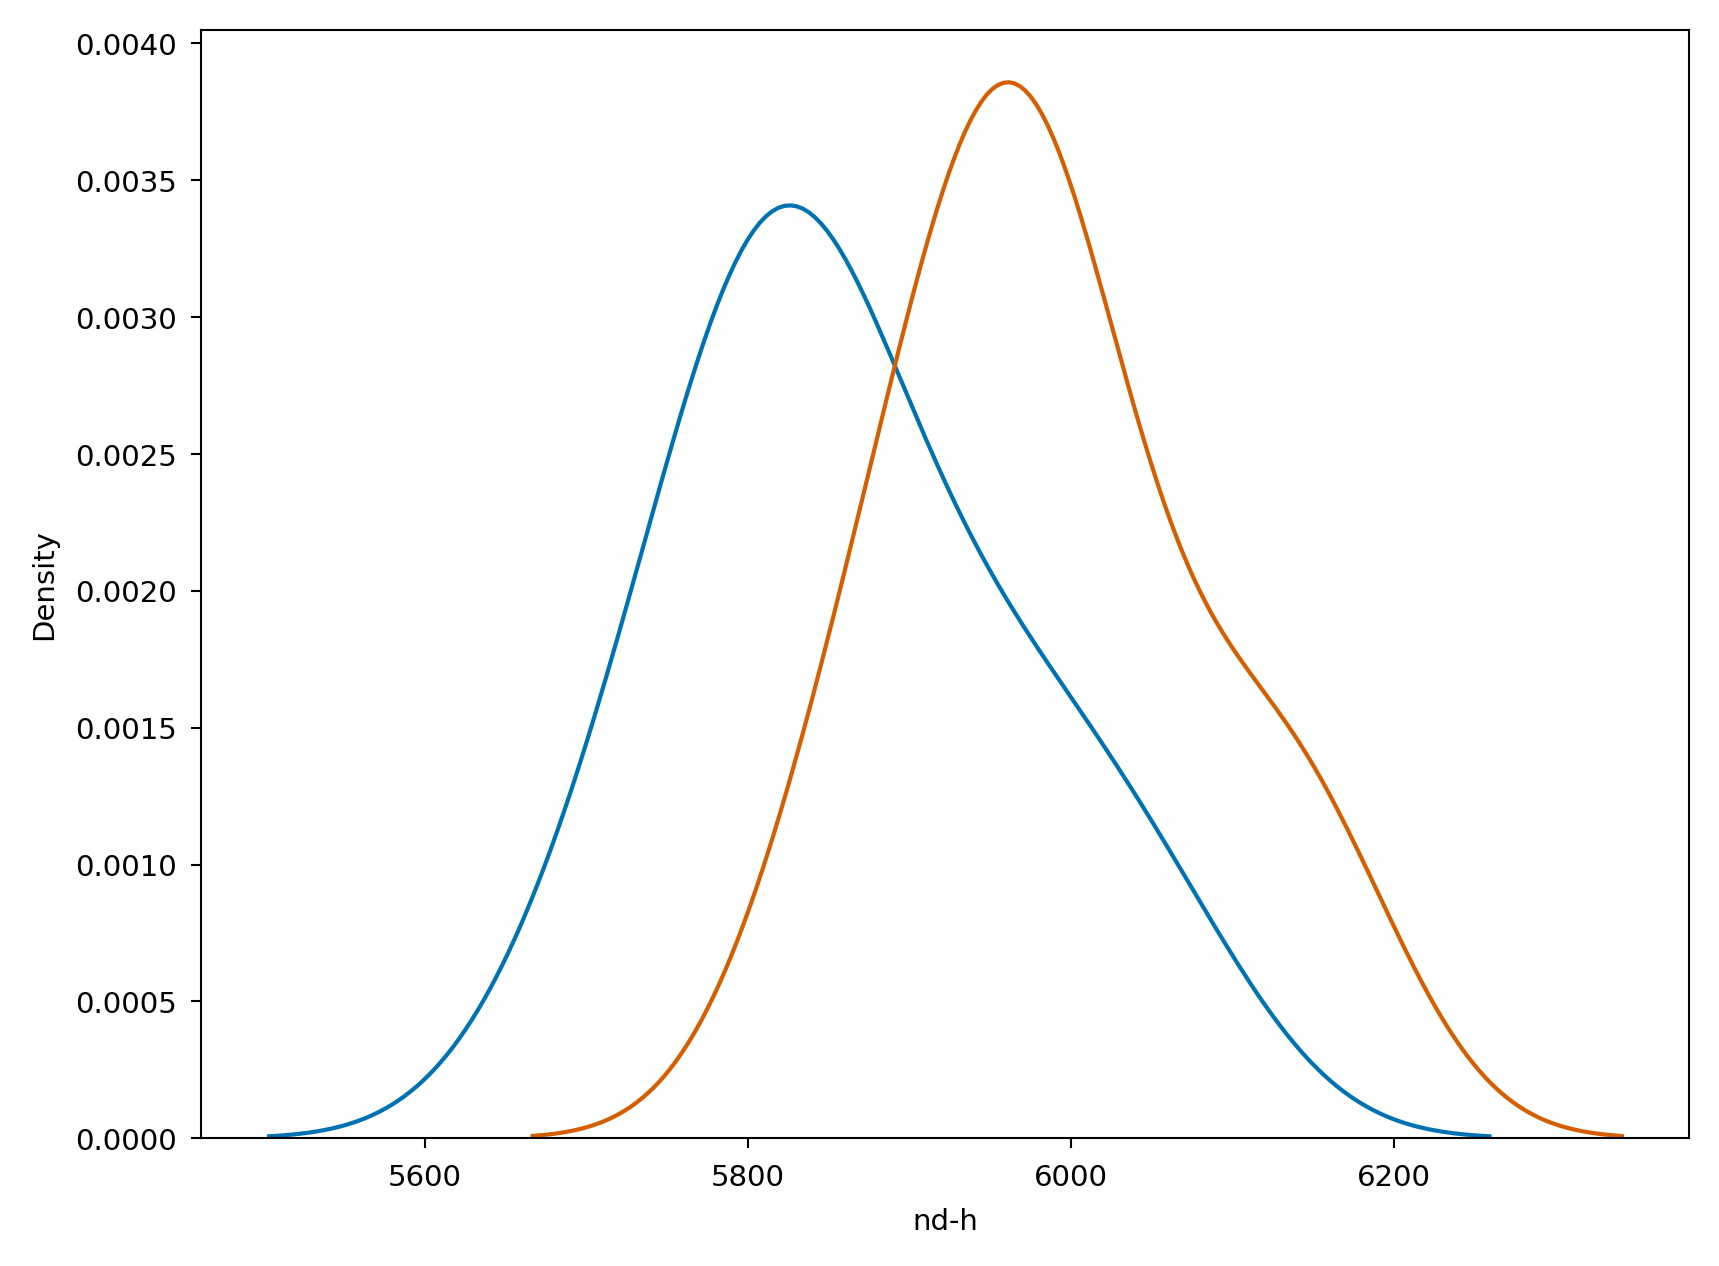

In [30]:
sns.kdeplot(x1)
sns.kdeplot(x2)

In [31]:
from scipy import stats

rvs1 = stats.norm.rvs(5, 10, 10)
rvs2 = stats.norm.rvs(5, 10, 10) + stats.norm.rvs(10, 1, 10)
res = ttest_rel(rvs1, rvs2)
res.statistic, res.pvalue, res.df

(-2.3337373262745653, 0.044474103853704615, 9)

<Axes: ylabel='Density'>

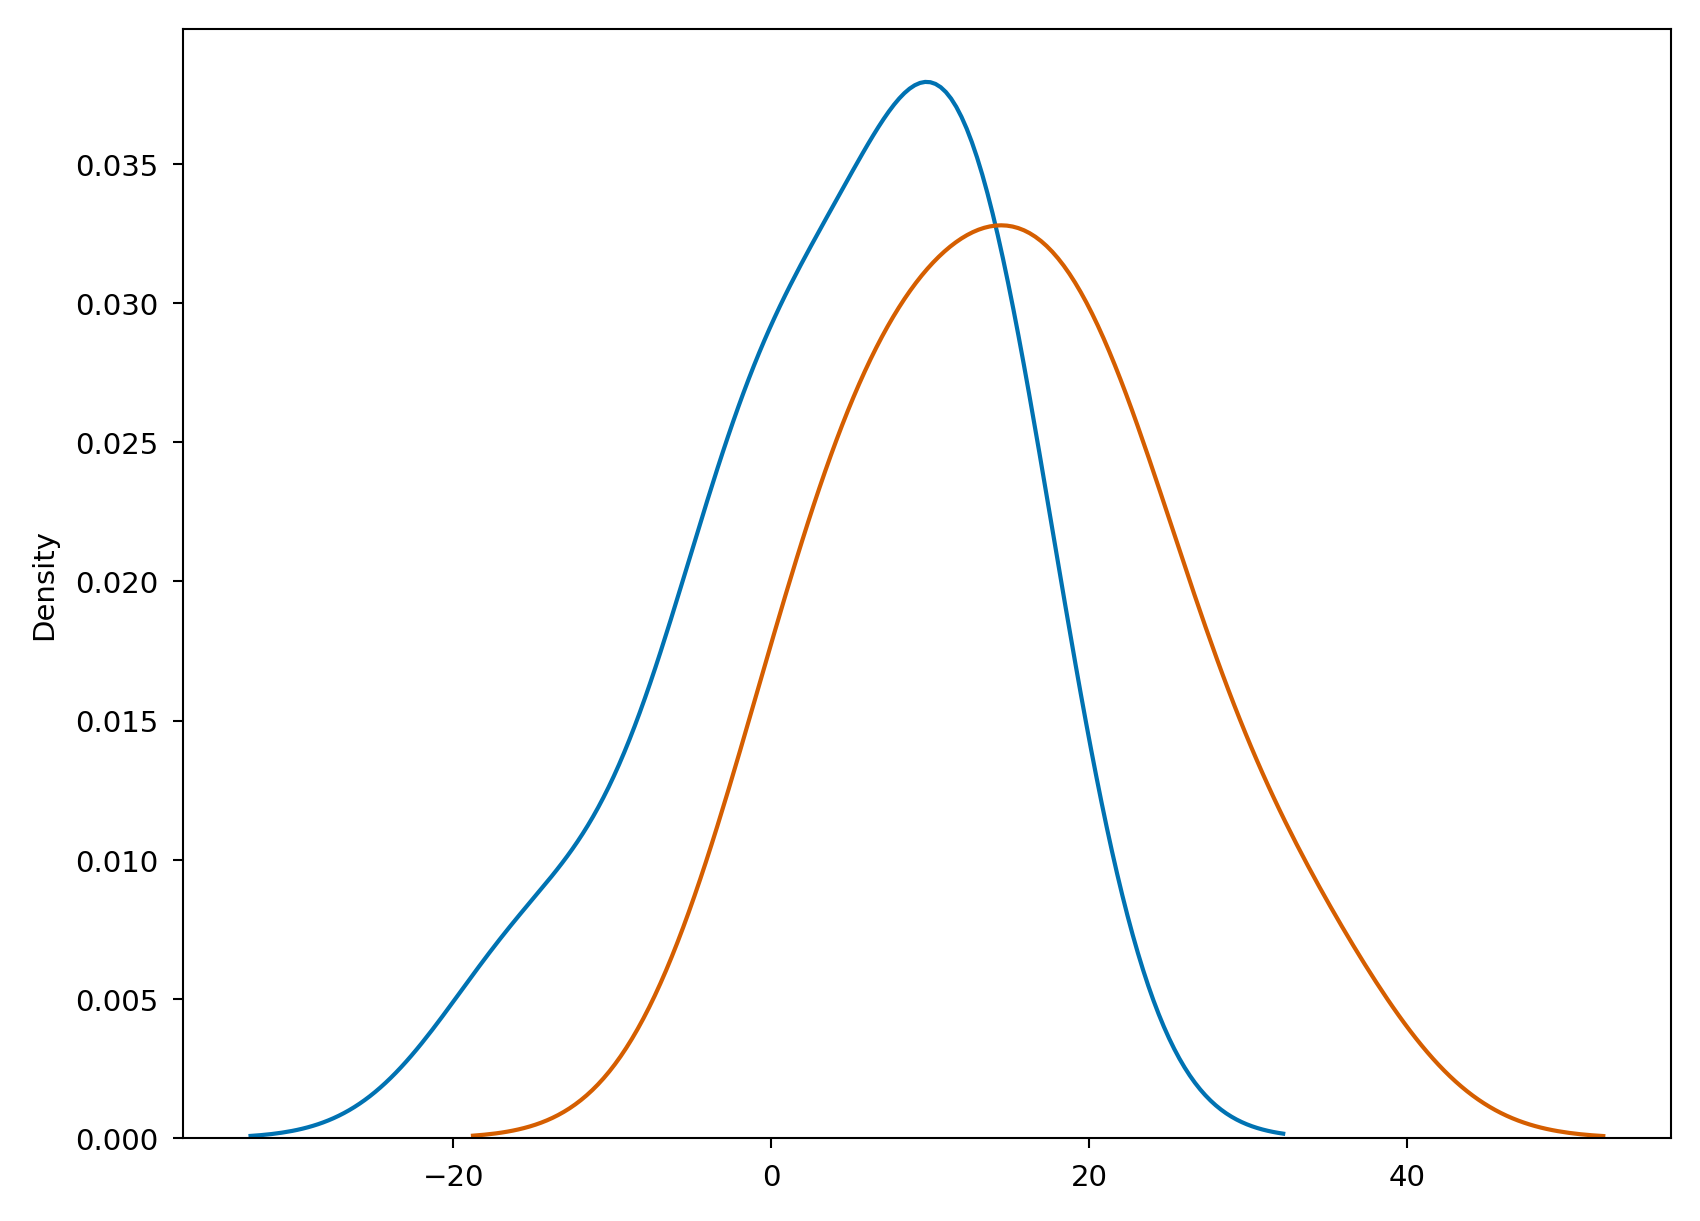

In [32]:
sns.kdeplot(rvs1)
sns.kdeplot(rvs2)